In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import xlrd
df = pd.read_csv("Registrants.csv")

In [3]:
df.shape

(239766, 4)

In [4]:
df.head()

,REGDATE,P_CLIENTCODE,Client ID,REGISTRANTS
0,1-Jan-15,AAP,2218.0,12
1,2-Jan-15,AAP,2218.0,14
2,3-Jan-15,AAP,2218.0,9
3,4-Jan-15,AAP,2218.0,6
4,5-Jan-15,AAP,2218.0,11


In [6]:
# List the unique values in the ['P_CLIENTCODE column']
# Shows the unique number of clients
df.P_CLIENTCODE.nunique()

451

In [8]:
# We need to convert 'REGDATE' from an object to time series
df.dtypes

REGDATE          object
P_CLIENTCODE     object
Client ID       float64
REGISTRANTS       int64
dtype: object

In [9]:
# Convert 'REGDATE'from an object to time series
df['REGDATE'] = pd.to_datetime(df['REGDATE'])

In [11]:
# Confirm that the object was changed. 
df.dtypes

REGDATE         datetime64[ns]
P_CLIENTCODE            object
Client ID              float64
REGISTRANTS              int64
dtype: object

In [13]:
# Determine the minimum and maximum dates of 'REGDATE'
df['REGDATE'].min(), df['REGDATE'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2019-10-07 00:00:00'))

In [14]:
df.shape

(239766, 4)

In [16]:
# Make a cols variable to remove columns that we do not need
cols = ['P_CLIENTCODE','Client ID']

In [17]:
df.drop(cols, axis=1, inplace=True)

In [18]:
df = df.sort_values('REGDATE')

In [20]:
# Determine if we have any null values
df.isnull().sum()

REGDATE        0
REGISTRANTS    0
dtype: int64

In [21]:
df = df.groupby('REGDATE')['REGISTRANTS'].sum().reset_index()

In [22]:
df.head()

,REGDATE,REGISTRANTS
0,2015-01-01,244
1,2015-01-02,354
2,2015-01-03,259
3,2015-01-04,228
4,2015-01-05,346


In [23]:
df = df.set_index('REGDATE')
df.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2019-09-28', '2019-09-29', '2019-09-30', '2019-10-01',
               '2019-10-02', '2019-10-03', '2019-10-04', '2019-10-05',
               '2019-10-06', '2019-10-07'],
              dtype='datetime64[ns]', name='REGDATE', length=1741, freq=None)

In [24]:
# Our current datetime data can be tricky to work with, 
# therefore, we will use the averages daily sales value 
# for that month instead, and we are using the start 
# of each month as the timestamp.

y = df['REGISTRANTS'].resample('MS').mean()

In [25]:
y['2017']

REGDATE
2017-01-01     457.806452
2017-02-01     561.928571
2017-03-01     736.064516
2017-04-01     591.200000
2017-05-01     672.225806
2017-06-01     587.433333
2017-07-01     755.709677
2017-08-01     835.225806
2017-09-01     636.333333
2017-10-01     679.354839
2017-11-01    1972.333333
2017-12-01    1157.451613
Freq: MS, Name: REGISTRANTS, dtype: float64

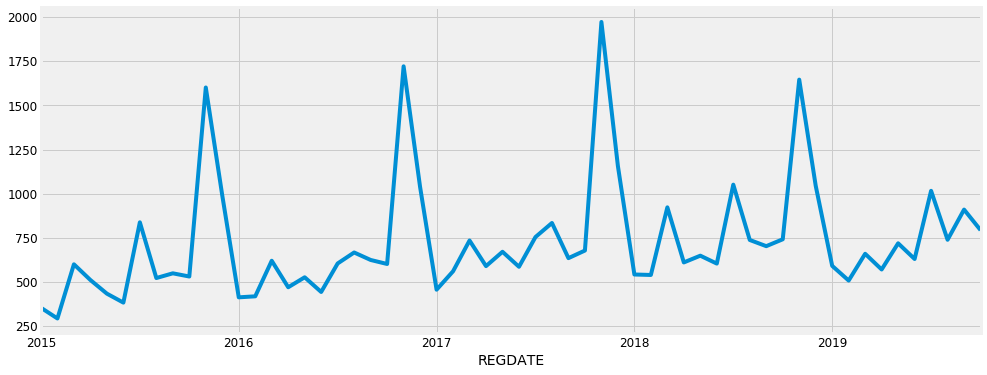

In [26]:
# View our data with a plot
y.plot(figsize=(15,6))
plt.show()

In [ ]:
# Visualize our data using a method called time-series decomposition that 
# allows us to decompose our time series into three distinct components:
# trend, seasonality, and noise.

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# ARIMA models are denoted with the notation ARIMA(p, d, q). 
# These three parameters account for seasonality, trend, and noise in data:

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
# Parameter selection for sales with the ARIMA time series model
# We are using a 'grid search' to find the optimal set of parameters
# that yields the best performance for your model

import warnings
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
# Fit the ARIMA model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### To help us understand the accuracy of our forecasts, we compare predicted registrants to real real registrants of the time series, and we set forecasts to start at 2019–01–01 to the end of the data.

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Registrants')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

### In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

### Root Mean Square Error (RMSE) tells us that our model was able to forecast the average monthly registrants in the test set within 111.59 of the real registrants. Our registrants monthly range is from around 250 to 1500. Thus, we have a model that is predicting well. 

## Producing and visualizing forecasts

In [ ]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Registrants')
plt.legend()
plt.show()

### Our model clearly captures registrants seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## Time Series Modeling with Prophet

### Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [ ]:
from fbprophet import Prophet